#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * (옵션) 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * (옵션) 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [7]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [8]:
# 데이터 불러오기
train_data = pd.read_csv('/content/drive/MyDrive/kt aivle/3차 미니 프로젝트/data01_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/kt aivle/3차 미니 프로젝트/data01_test.csv')
feature = pd.read_csv('/content/drive/MyDrive/kt aivle/3차 미니 프로젝트/features.csv')

In [9]:
# 불필요 칼럼 삭제
train_data.drop('subject', axis=1, inplace=True)
test_data.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [10]:
train_data, test_data

(      tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
 0              0.288508          -0.009196          -0.103362   
 1              0.265757          -0.016576          -0.098163   
 2              0.278709          -0.014511          -0.108717   
 3              0.289795          -0.035536          -0.150354   
 4              0.394807           0.034098           0.091229   
 ...                 ...                ...                ...   
 5876           0.277194          -0.012389          -0.131974   
 5877           0.191568           0.013328          -0.105174   
 5878           0.267981          -0.018348          -0.107440   
 5879           0.212787          -0.048130          -0.121001   
 5880           0.283815          -0.040658          -0.138018   
 
       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
 0            -0.988986         -0.962797         -0.967422         -0.989000   
 1            -0.989551         -0.994636   

In [11]:
# 데이터 형태
train_data.shape, test_data.shape

((5881, 562), (1471, 562))

In [12]:
#데이터 정보
train_data.info(), test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 6.3+ MB


(None, None)

In [13]:
# 데이터 기초통계량
train_data.describe(), test_data.describe()

(       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
 count        5881.000000        5881.000000        5881.000000   
 mean            0.274811          -0.017799          -0.109396   
 std             0.067614           0.039422           0.058373   
 min            -0.503823          -0.684893          -1.000000   
 25%             0.262919          -0.024877          -0.121051   
 50%             0.277154          -0.017221          -0.108781   
 75%             0.288526          -0.010920          -0.098163   
 max             1.000000           1.000000           1.000000   
 
        tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
 count       5881.000000       5881.000000       5881.000000       5881.000000   
 mean          -0.603138         -0.509815         -0.604058         -0.628151   
 std            0.448807          0.501815          0.417319          0.424345   
 min           -1.000000         -0.999844         -0.999667       

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [14]:
target = 'Activity'

x = train_data.drop(target, axis = 1)
y = train_data.loc[:, target]

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [16]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [17]:
# y 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [18]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 20)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1

In [24]:
nfeatures = x_train.shape[1] #num of columns

# Sequential
model1 = Sequential( [Input(shape = (nfeatures,)),
                     Dense(6, activation = 'softmax')] )

model1.compile(optimizer=Adam(learning_rate=0.001), loss= 'sparse_categorical_crossentropy')

history1 = model1.fit(x_train, y_train, epochs = 50, validation_split=0.2).history

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.3595 - val_loss: 0.8293
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7851 - val_loss: 0.6128
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5992 - val_loss: 0.5040
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4917 - val_loss: 0.4273
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4308 - val_loss: 0.3761
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3794 - val_loss: 0.3534
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3475 - val_loss: 0.3096
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3192 - val_loss: 0.2910
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3055 - val_loss: 0.2735
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2826 - val_loss: 0.2570
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2676 - val_loss: 0.2395
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

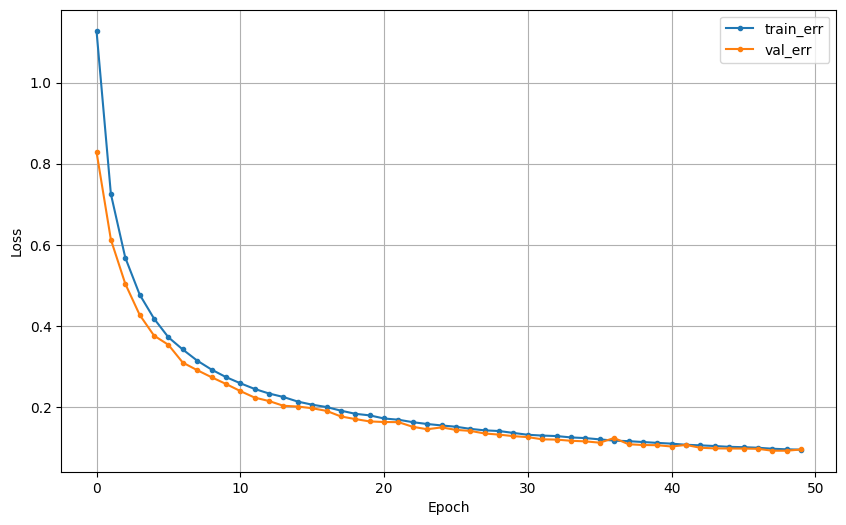

In [25]:
dl_history_plot(history1)

In [21]:
p1 = model1.predict(x_val)
p1 = p1.argmax(axis = 1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [26]:
print(confusion_matrix(y_val, p1))
print(classification_report(y_val, p1))

[[202   0   0   0   0   0]
 [  0 203   8   0   0   0]
 [  0  15 199   0   0   0]
 [  0   0   0 202   0   1]
 [  0   0   0   0 170   0]
 [  0   0   0   0   0 177]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.93      0.96      0.95       211
           2       0.96      0.93      0.95       214
           3       1.00      1.00      1.00       203
           4       1.00      1.00      1.00       170
           5       0.99      1.00      1.00       177

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



### (2) 모델2

In [28]:
nfeatures = x_train.shape[1] #num of columns

# Sequential
model2 = Sequential( [Input(shape = (nfeatures,)),
                      Dense(128, activation = 'relu'),
                      Dense(64, activation = 'relu'),
                      Dense(32, activation = 'relu'),
                      Dense(16, activation = 'relu'),
                      Dense(6, activation = 'softmax')] )

model2.compile(optimizer=Adam(learning_rate=0.001), loss= 'sparse_categorical_crossentropy')

history2 = model2.fit(x_train, y_train, epochs = 50, validation_split=0.2).history

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.0992 - val_loss: 0.3851
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3446 - val_loss: 0.2038
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2278 - val_loss: 0.1801
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1535 - val_loss: 0.2067
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1407 - val_loss: 0.1362
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1008 - val_loss: 0.1106
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1155 - val_loss: 0.1033
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0986 - val_loss: 0.0919
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1065 - val_loss: 0.0844
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0783 - val_loss: 0.1871
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1022 - val_loss: 0.0700
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/s

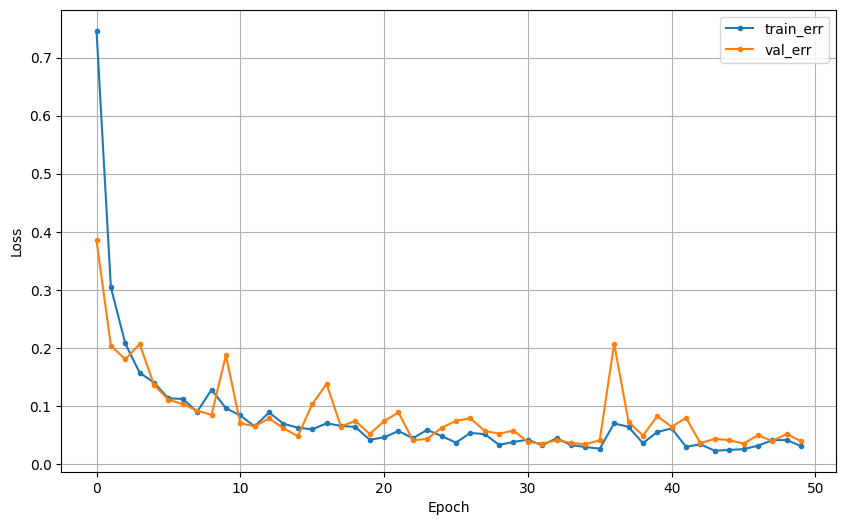

In [29]:
dl_history_plot(history2)

In [30]:
p2 = model2.predict(x_val)
p2 = p2.argmax(axis = 1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [31]:
print(confusion_matrix(y_val, p2))
print(classification_report(y_val, p2))

[[202   0   0   0   0   0]
 [  0 200  11   0   0   0]
 [  0   6 208   0   0   0]
 [  0   0   0 202   0   1]
 [  0   0   0   0 170   0]
 [  0   0   0   1   0 176]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.97      0.95      0.96       211
           2       0.95      0.97      0.96       214
           3       1.00      1.00      1.00       203
           4       1.00      1.00      1.00       170
           5       0.99      0.99      0.99       177

    accuracy                           0.98      1177
   macro avg       0.99      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



### (3) 모델3

In [33]:
nfeatures = x_train.shape[1] #num of columns

# Sequential
model3 = Sequential( [Input(shape = (nfeatures,)),
                      Dense(128, activation = 'relu'),
                      Dense(64, activation = 'relu'),
                      Dense(32, activation = 'relu'),
                      Dense(16, activation = 'relu'),
                      Dense(6, activation = 'softmax')] )

model3.compile(optimizer=Adam(learning_rate=0.001), loss= 'sparse_categorical_crossentropy')

history3 = model3.fit(x_train, y_train, epochs = 100, validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1.2596 - val_loss: 0.3567
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3628 - val_loss: 0.2248
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2224 - val_loss: 0.1928
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1847 - val_loss: 0.1268
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1457 - val_loss: 0.1333
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1433 - val_loss: 0.1020
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1039 - val_loss: 0.1944
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1055 - val_loss: 0.1314
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1172 - val_loss: 0.0680
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0762 - val_loss: 0.0671
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0770 - val_loss: 0.0580
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━━━

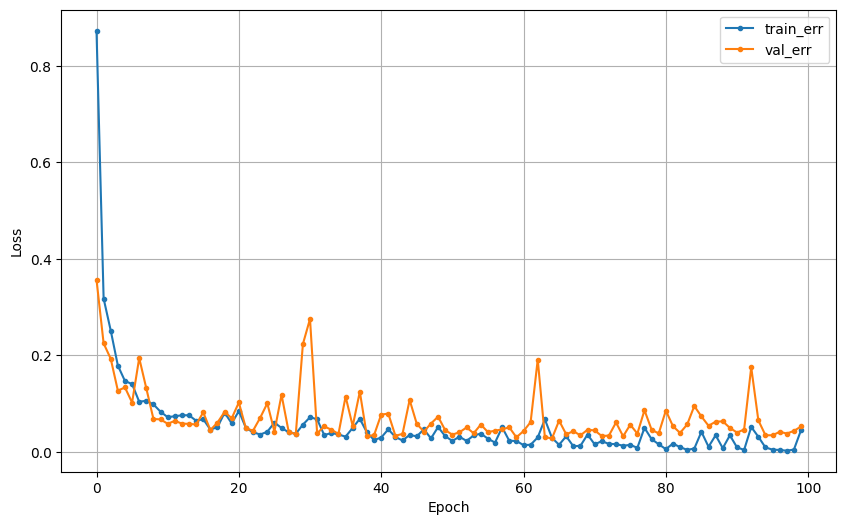

In [34]:
dl_history_plot(history3)

In [35]:
p3 = model3.predict(x_val)
p3 = p3.argmax(axis = 1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [36]:
print(confusion_matrix(y_val, p3))
print(classification_report(y_val, p3))

[[202   0   0   0   0   0]
 [  0 207   4   0   0   0]
 [  0  12 202   0   0   0]
 [  0   0   0 202   0   1]
 [  0   0   0   2 168   0]
 [  0   0   0   3   0 174]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.95      0.98      0.96       211
           2       0.98      0.94      0.96       214
           3       0.98      1.00      0.99       203
           4       1.00      0.99      0.99       170
           5       0.99      0.98      0.99       177

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



In [144]:
accuracy = accuracy_score(y_val, p3)
print(f'정확도 (Accuracy): {accuracy}')

정확도 (Accuracy): 0.9813084112149533


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam

# nfeatures = x_train.shape[1] # num of columns
nfeatures = x_train.shape[1]  # 이 부분은 x_train 데이터에 맞게 설정하세요.

val_accuracies = []

for i in range(5):  # 5번 훈련
    # 모델 정의
    model3 = Sequential([
        Input(shape=(nfeatures,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(6, activation='softmax')
    ])

    model3.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

    # 모델 훈련
    history3 = model3.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0)  # verbose=0으로 출력 생략

    # val_accuracy 저장
    val_accuracy = history3.history['val_accuracy']  # 수정된 부분
    val_accuracies.append(val_accuracy[-1])  # 마지막 epoch의 val_accuracy 저장

# 평균 val_accuracy 계산
average_val_accuracy = np.mean(val_accuracies)
print(f'5번 훈련의 평균 val_accuracy: {average_val_accuracy:.4f}')

KeyError: 'val_accuracy'

### (4) 모델4

In [37]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

nfeatures = x_train.shape[1]  # num of columns

# Sequential
model4 = Sequential([
    Input(shape=(nfeatures,)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # 첫 번째 Dense 레이어에 L2 규제 추가
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # 두 번째 Dense 레이어에 L2 규제 추가
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # 세 번째 Dense 레이어에 L2 규제 추가
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),  # 네 번째 Dense 레이어에 L2 규제 추가
    Dense(6, activation='softmax')  # 출력 레이어
])

model4.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

history4 = model4.fit(x_train, y_train, epochs=100, validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 3.6815 - val_loss: 1.4456
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.3324 - val_loss: 1.0210
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9836 - val_loss: 1.0377
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9336 - val_loss: 0.7962
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7832 - val_loss: 0.7261
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7162 - val_loss: 0.6284
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6536 - val_loss: 0.6128
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6340 - val_loss: 0.6415
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6379 - val_loss: 0.5515
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5898 - val_loss: 0.5363
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5997 - val_loss: 0.5261
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━━━

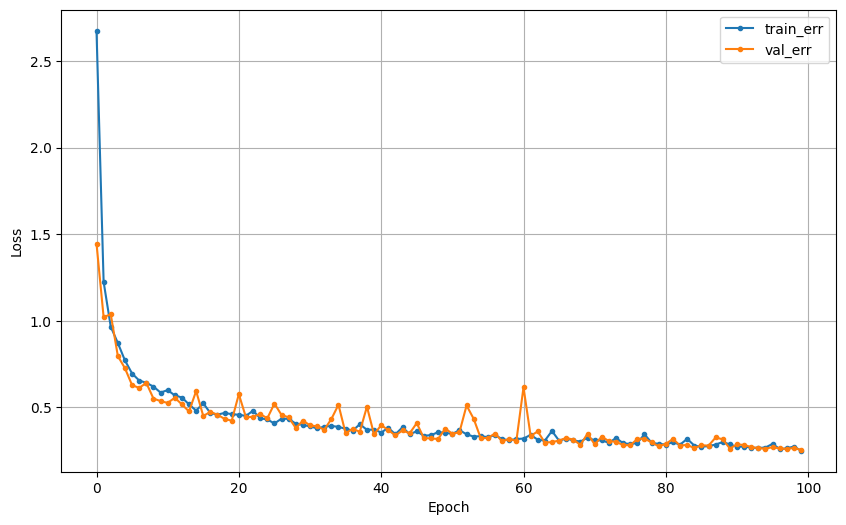

In [38]:
dl_history_plot(history4)

In [39]:
p4 = model4.predict(x_val)
p4 = p4.argmax(axis = 1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [40]:
print(confusion_matrix(y_val, p4))
print(classification_report(y_val, p4))

[[202   0   0   0   0   0]
 [  0 202   9   0   0   0]
 [  0   9 205   0   0   0]
 [  0   0   0 201   1   1]
 [  0   0   0   0 169   1]
 [  0   0   0   0   3 174]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.96      0.96      0.96       211
           2       0.96      0.96      0.96       214
           3       1.00      0.99      1.00       203
           4       0.98      0.99      0.99       170
           5       0.99      0.98      0.99       177

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



### (5) 모델5

In [50]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

nfeatures = x_train.shape[1]  # num of columns

# Sequential
model5 = Sequential([
    Input(shape=(nfeatures,)),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),  # 첫 번째 Dense 레이어에 L2 규제 추가
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # 첫 번째 Dense 레이어에 L2 규제 추가
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # 두 번째 Dense 레이어에 L2 규제 추가
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # 세 번째 Dense 레이어에 L2 규제 추가
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),  # 네 번째 Dense 레이어에 L2 규제 추가
    Dense(6, activation='softmax')  # 출력 레이어
])

model5.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

history5 = model5.fit(x_train, y_train, epochs=100, validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 6.2214 - val_loss: 1.6463
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5338 - val_loss: 1.1174
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0723 - val_loss: 1.0138
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.9167 - val_loss: 0.8715
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.8442 - val_loss: 0.7640
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.7872 - val_loss: 0.7952
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.7427 - val_loss: 0.7391
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7154 - val_loss: 0.6149
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6918 - val_loss: 0.6553
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6258 - val_loss: 0.6049
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6276 - val_loss: 0.5958
Epoch 12/100
118/118 ━━━━━━━━━━━━

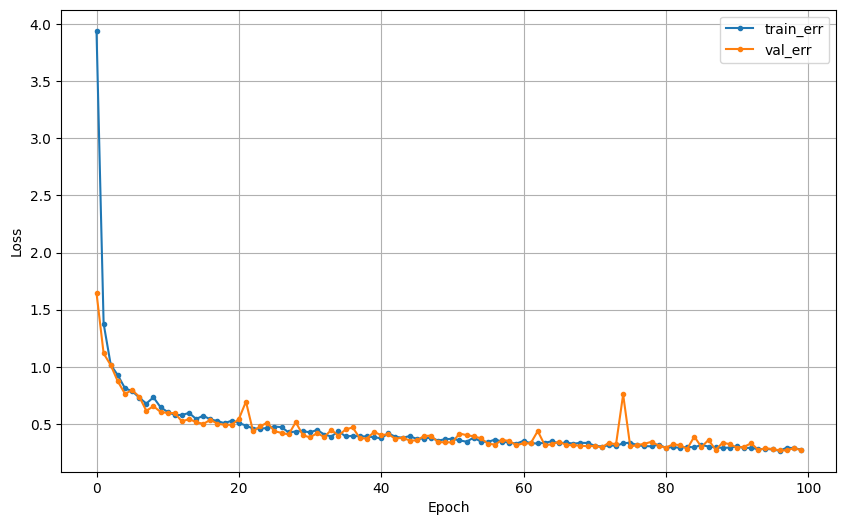

In [51]:
dl_history_plot(history5)

In [52]:
p5 = model5.predict(x_val)
p5 = p5.argmax(axis = 1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [53]:
print(confusion_matrix(y_val, p5))
print(classification_report(y_val, p5))

[[200   0   0   0   0   2]
 [  0 181  30   0   0   0]
 [  0   2 212   0   0   0]
 [  0   0   0 202   0   1]
 [  0   0   0   6 162   2]
 [  0   0   0   2   1 174]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       202
           1       0.99      0.86      0.92       211
           2       0.88      0.99      0.93       214
           3       0.96      1.00      0.98       203
           4       0.99      0.95      0.97       170
           5       0.97      0.98      0.98       177

    accuracy                           0.96      1177
   macro avg       0.97      0.96      0.96      1177
weighted avg       0.96      0.96      0.96      1177



### (6) 모델6

In [76]:
nfeatures = x_train.shape[1] #num of columns

# Sequential
model6 = Sequential( [Input(shape = (nfeatures,)),
                      Dense(128, activation = 'relu'),
                      Dropout(0.5),
                      Dense(64, activation = 'relu'),
                      Dropout(0.5),
                      Dense(32, activation = 'relu'),
                      Dropout(0.5),
                      Dense(16, activation = 'relu'),
                      Dropout(0.5),
                      Dense(6, activation = 'softmax')] )

model6.compile(optimizer=Adam(learning_rate=0.001), loss= 'sparse_categorical_crossentropy')

history6 = model6.fit(x_train, y_train, epochs = 100, validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1.8455 - val_loss: 1.6280
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6431 - val_loss: 1.2731
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4327 - val_loss: 1.0086
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2752 - val_loss: 0.8922
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1200 - val_loss: 0.7750
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0524 - val_loss: 0.7621
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9766 - val_loss: 0.7361
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9392 - val_loss: 0.7204
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8841 - val_loss: 0.7148
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8359 - val_loss: 0.6975
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8464 - val_loss: 0.6707
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━━━━

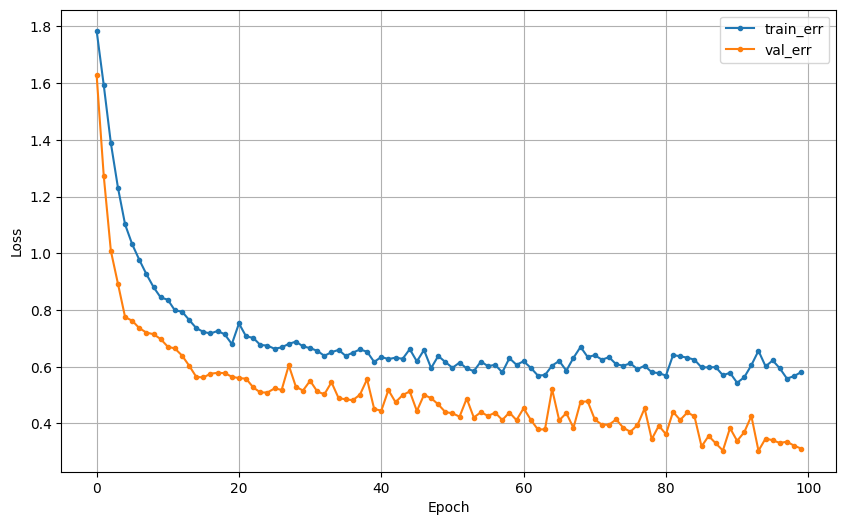

In [77]:
dl_history_plot(history6)

In [78]:
p6 = model6.predict(x_val)
p6 = p6.argmax(axis = 1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [79]:
print(confusion_matrix(y_val, p6))
print(classification_report(y_val, p6))

[[202   0   0   0   0   0]
 [  0 187  24   0   0   0]
 [  0  37 177   0   0   0]
 [  0   0   0 201   1   1]
 [  0   0   0   5 103  62]
 [  0   0   0   0   2 175]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.83      0.89      0.86       211
           2       0.88      0.83      0.85       214
           3       0.98      0.99      0.98       203
           4       0.97      0.61      0.75       170
           5       0.74      0.99      0.84       177

    accuracy                           0.89      1177
   macro avg       0.90      0.88      0.88      1177
weighted avg       0.90      0.89      0.88      1177



### (7) 모델7

In [80]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

nfeatures = x_train.shape[1]  # num of columns

# Sequential
model7 = Sequential([
    Input(shape=(nfeatures,)),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),  # 첫 번째 Dense 레이어에 L2 규제 추가
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # 첫 번째 Dense 레이어에 L2 규제 추가
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # 두 번째 Dense 레이어에 L2 규제 추가
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # 세 번째 Dense 레이어에 L2 규제 추가
    Dropout(0.5),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),  # 네 번째 Dense 레이어에 L2 규제 추가
    Dropout(0.5),
    Dense(6, activation='softmax')  # 출력 레이어
])

model7.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

history7 = model7.fit(x_train, y_train, epochs=100, validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 7.7675 - val_loss: 3.5019
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.1338 - val_loss: 2.1700
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.1459 - val_loss: 1.7134
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7481 - val_loss: 1.4943
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.5455 - val_loss: 1.3476
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.4361 - val_loss: 1.2802
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.3848 - val_loss: 1.2656
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.3406 - val_loss: 1.2345
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.3233 - val_loss: 1.2139
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.2944 - val_loss: 1.1978
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.2868 - val_loss: 1.1880
Epoch 12/100
118/118 ━━━━━━━━━━

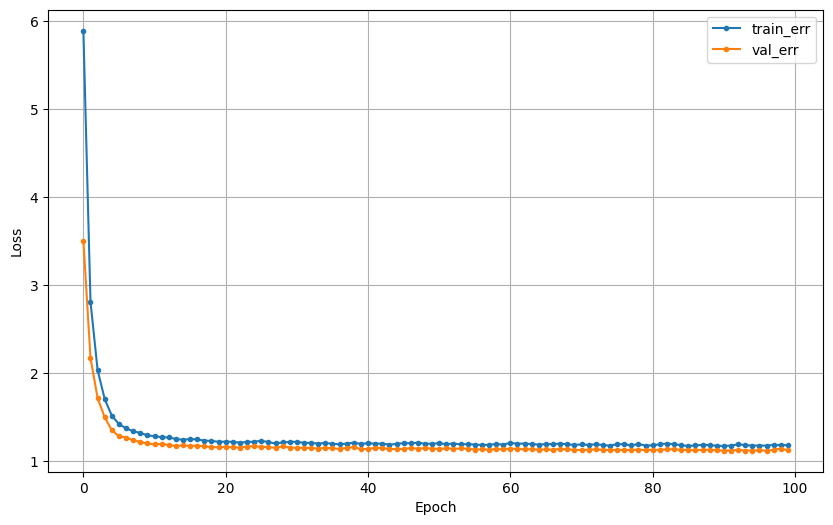

In [81]:
dl_history_plot(history7)

In [82]:
p7 = model7.predict(x_val)
p7 = p7.argmax(axis = 1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [83]:
print(confusion_matrix(y_val, p7))
print(classification_report(y_val, p7))

[[202   0   0   0   0   0]
 [211   0   0   0   0   0]
 [214   0   0   0   0   0]
 [  0   0   0 144   7  52]
 [  0   0   0  82  82   6]
 [  0   0   0  68   2 107]]
              precision    recall  f1-score   support

           0       0.32      1.00      0.49       202
           1       0.00      0.00      0.00       211
           2       0.00      0.00      0.00       214
           3       0.49      0.71      0.58       203
           4       0.90      0.48      0.63       170
           5       0.65      0.60      0.63       177

    accuracy                           0.45      1177
   macro avg       0.39      0.47      0.39      1177
weighted avg       0.37      0.45      0.37      1177



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### (8) 모델8

In [91]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

nfeatures = x_train.shape[1]  # num of columns

# Sequential
model8 = Sequential([
    Input(shape=(nfeatures,)),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),  # 첫 번째 Dense 레이어에 L2 규제 추가
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # 첫 번째 Dense 레이어에 L2 규제 추가
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # 두 번째 Dense 레이어에 L2 규제 추가
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # 세 번째 Dense 레이어에 L2 규제 추가
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # 네 번째 Dense 레이어에 L2 규제 추가
    Dropout(0.5),
    Dense(6, activation='softmax')  # 출력 레이어
])

model8.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

history8 = model8.fit(x_train, y_train, epochs=50, validation_split=0.2).history

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 9.8452 - val_loss: 4.0468
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.5831 - val_loss: 2.2890
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.1956 - val_loss: 1.6514
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.6705 - val_loss: 1.3860
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.4068 - val_loss: 1.2483
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.2816 - val_loss: 1.1348
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.1726 - val_loss: 1.0810
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.1146 - val_loss: 1.0128
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.0481 - val_loss: 0.9739
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.0360 - val_loss: 0.9537
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.0365 - val_loss: 0.9456
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 

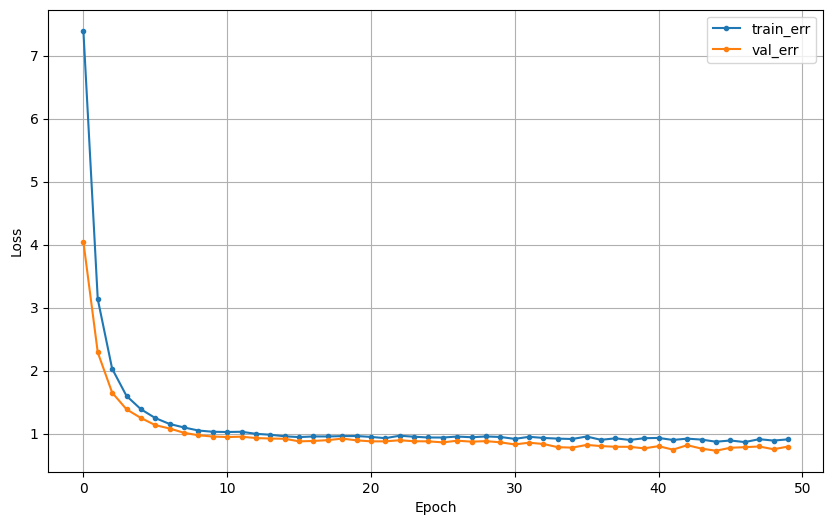

In [92]:
dl_history_plot(history8)

In [93]:
p8 = model8.predict(x_val)
p8 = p8.argmax(axis = 1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [94]:
print(confusion_matrix(y_val, p8))
print(classification_report(y_val, p8))

[[202   0   0   0   0   0]
 [  7 193  11   0   0   0]
 [  0  40 174   0   0   0]
 [  0   0   0 184   0  19]
 [  0   0   0  59 111   0]
 [  0   0   0 130   0  47]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       202
           1       0.83      0.91      0.87       211
           2       0.94      0.81      0.87       214
           3       0.49      0.91      0.64       203
           4       1.00      0.65      0.79       170
           5       0.71      0.27      0.39       177

    accuracy                           0.77      1177
   macro avg       0.82      0.76      0.76      1177
weighted avg       0.82      0.77      0.77      1177



### (9) 모델9

In [97]:
nfeatures = x_train.shape[1] #num of columns

# Sequential
model9 = Sequential( [Input(shape = (nfeatures,)),
                      Dense(128, activation = 'relu'),
                      Dropout(0.3),
                      Dense(64, activation = 'relu'),
                      Dropout(0.3),
                      Dense(32, activation = 'relu'),
                      Dropout(0.3),
                      Dense(16, activation = 'relu'),
                      Dropout(0.3),
                      Dense(6, activation = 'softmax')] )

model9.compile(optimizer=Adam(learning_rate=0.001), loss= 'sparse_categorical_crossentropy')

history9 = model9.fit(x_train, y_train, epochs = 100, validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1.6395 - val_loss: 1.1497
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2145 - val_loss: 0.6610
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8646 - val_loss: 0.5343
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7158 - val_loss: 0.4051
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6101 - val_loss: 0.4091
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5304 - val_loss: 0.3223
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.4660 - val_loss: 0.2800
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4183 - val_loss: 0.3269
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4273 - val_loss: 0.2834
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3991 - val_loss: 0.2665
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3655 - val_loss: 0.2837
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━━━

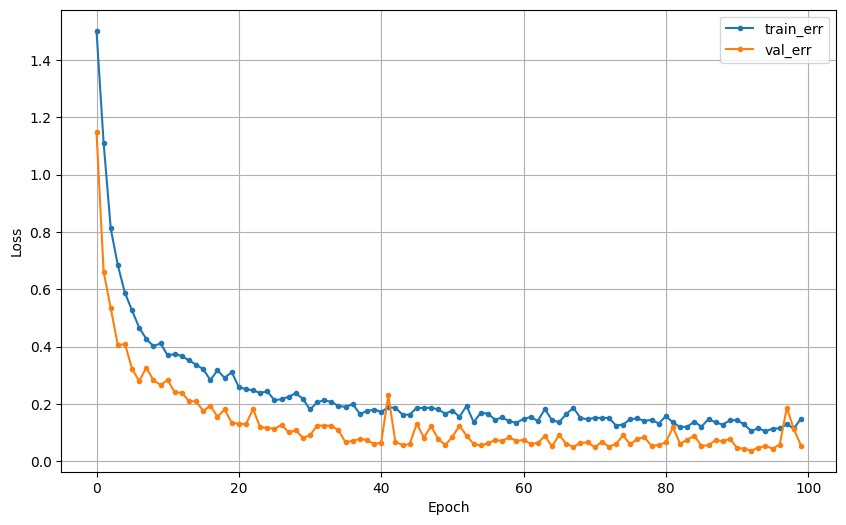

In [98]:
dl_history_plot(history9)

In [99]:
p9 = model9.predict(x_val)
p9 = p9.argmax(axis = 1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [100]:
print(confusion_matrix(y_val, p9))
print(classification_report(y_val, p9))

[[202   0   0   0   0   0]
 [  0 186  25   0   0   0]
 [  0   4 210   0   0   0]
 [  0   0   0 200   1   2]
 [  0   0   0   0 170   0]
 [  0   0   0   0   1 176]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.98      0.88      0.93       211
           2       0.89      0.98      0.94       214
           3       1.00      0.99      0.99       203
           4       0.99      1.00      0.99       170
           5       0.99      0.99      0.99       177

    accuracy                           0.97      1177
   macro avg       0.97      0.97      0.97      1177
weighted avg       0.97      0.97      0.97      1177



### (10) 모델10

In [104]:
nfeatures = x_train.shape[1] #num of columns

# Sequential
model10 = Sequential( [Input(shape = (nfeatures,)),
                      Dense(1024, activation = 'relu'),
                      Dense(512, activation = 'relu'),
                      Dense(256, activation = 'relu'),
                      Dense(128, activation = 'relu'),
                      Dense(64, activation = 'relu'),
                      Dense(32, activation = 'relu'),
                      Dense(16, activation = 'relu'),
                      Dense(6, activation = 'softmax')] )

model10.compile(optimizer=Adam(learning_rate=0.001), loss= 'sparse_categorical_crossentropy')

history10 = model10.fit(x_train, y_train, epochs = 100, validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 1.0188 - val_loss: 0.5254
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.3600 - val_loss: 0.2438
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.2271 - val_loss: 0.1609
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.1721 - val_loss: 0.2110
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.1809 - val_loss: 0.2027
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.1378 - val_loss: 0.1772
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1243 - val_loss: 0.1934
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.1714 - val_loss: 0.1788
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.1248 - val_loss: 0.0697
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.1005 - val_loss: 0.0697
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0768 - val_loss: 0.1121
Epoch 12/100
118/118 ━━━━━━━━━

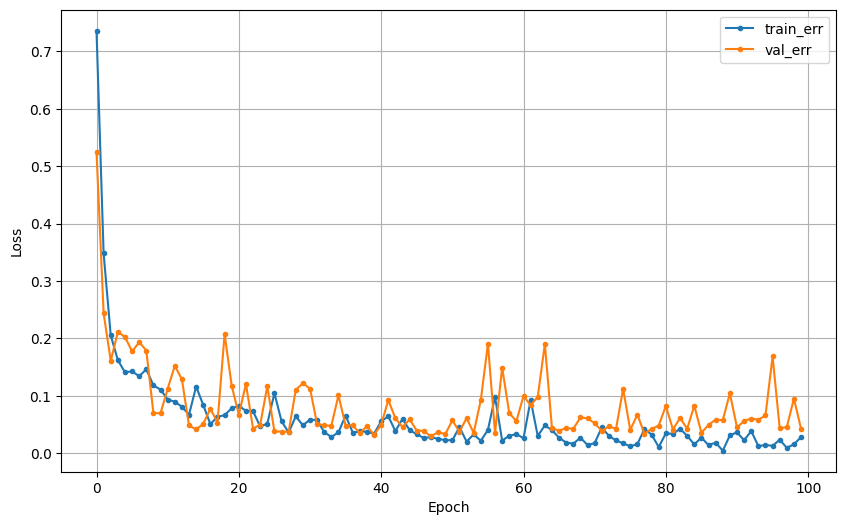

In [105]:
dl_history_plot(history10)

In [106]:
p10 = model10.predict(x_val)
p10 = p10.argmax(axis = 1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [107]:
print(confusion_matrix(y_val, p10))
print(classification_report(y_val, p10))

[[202   0   0   0   0   0]
 [  0 204   7   0   0   0]
 [  0  10 204   0   0   0]
 [  0   0   0 202   0   1]
 [  0   0   0   1 169   0]
 [  0   0   0   0   0 177]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.95      0.97      0.96       211
           2       0.97      0.95      0.96       214
           3       1.00      1.00      1.00       203
           4       1.00      0.99      1.00       170
           5       0.99      1.00      1.00       177

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



### (11) 모델11

In [111]:
nfeatures = x_train.shape[1] #num of columns

# Sequential
model11 = Sequential( [Input(shape = (nfeatures,)),
                      Dense(512, activation = 'relu'),
                      Dense(256, activation = 'relu'),
                      Dense(128, activation = 'relu'),
                      Dense(64, activation = 'relu'),
                      Dense(32, activation = 'relu'),
                      Dense(16, activation = 'relu'),
                      Dense(6, activation = 'softmax')] )

model11.compile(optimizer=Adam(learning_rate=0.001), loss= 'sparse_categorical_crossentropy')

history11 = model11.fit(x_train, y_train, epochs = 100, validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.9769 - val_loss: 0.3644
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3611 - val_loss: 0.2192
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2373 - val_loss: 0.2995
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2229 - val_loss: 0.1141
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1222 - val_loss: 0.1141
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1549 - val_loss: 0.1085
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1046 - val_loss: 0.1547
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0958 - val_loss: 0.0877
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0837 - val_loss: 0.0682
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0760 - val_loss: 0.0708
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0885 - val_loss: 0.1842
Epoch 12/100
118/118 ━━━━━━━━━━━━━━

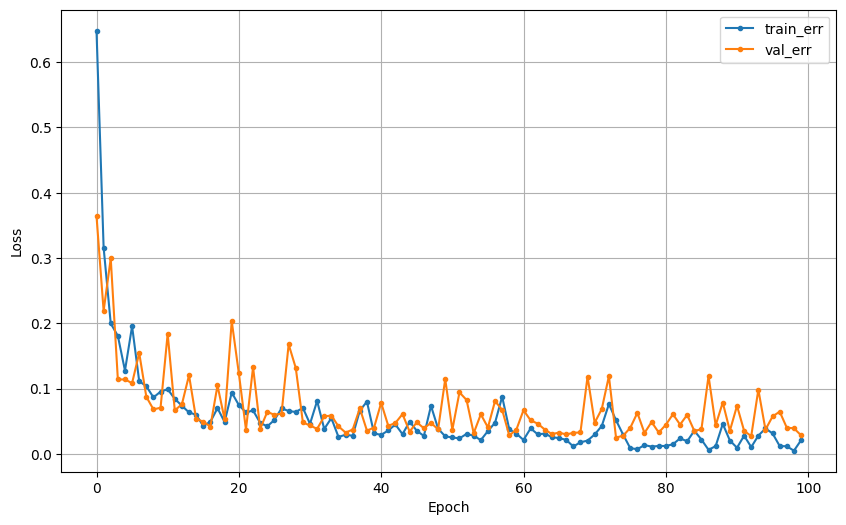

In [112]:
dl_history_plot(history11)

In [113]:
p11 = model11.predict(x_val)
p11 = p11.argmax(axis = 1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [114]:
print(confusion_matrix(y_val, p11))
print(classification_report(y_val, p11))

[[202   0   0   0   0   0]
 [  0 202   9   0   0   0]
 [  0   9 205   0   0   0]
 [  0   0   0 202   0   1]
 [  0   0   0   0 170   0]
 [  0   0   0   0   0 177]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.96      0.96      0.96       211
           2       0.96      0.96      0.96       214
           3       1.00      1.00      1.00       203
           4       1.00      1.00      1.00       170
           5       0.99      1.00      1.00       177

    accuracy                           0.98      1177
   macro avg       0.98      0.99      0.99      1177
weighted avg       0.98      0.98      0.98      1177



### (12) 모델12

In [137]:
nfeatures = x_train.shape[1] #num of columns

# Sequential
model12 = Sequential( [Input(shape = (nfeatures,)),
                      Dense(128, activation = 'relu'),
                      Dense(64, activation = 'relu'),
                      Dense(32, activation = 'relu'),
                      Dense(16, activation = 'relu'),
                      Dense(6, activation = 'softmax')] )

model12.compile(optimizer=Adam(learning_rate=0.001), loss= 'sparse_categorical_crossentropy')

history12 = model12.fit(x_train, y_train, epochs = 50, validation_split=0.2).history

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1.2952 - val_loss: 0.4562
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4213 - val_loss: 0.2430
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2458 - val_loss: 0.1980
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1869 - val_loss: 0.1464
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1676 - val_loss: 0.1590
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1456 - val_loss: 0.1036
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1944 - val_loss: 0.1073
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1023 - val_loss: 0.0885
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0865 - val_loss: 0.0904
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0953 - val_loss: 0.0728
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0969 - val_loss: 0.0660
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

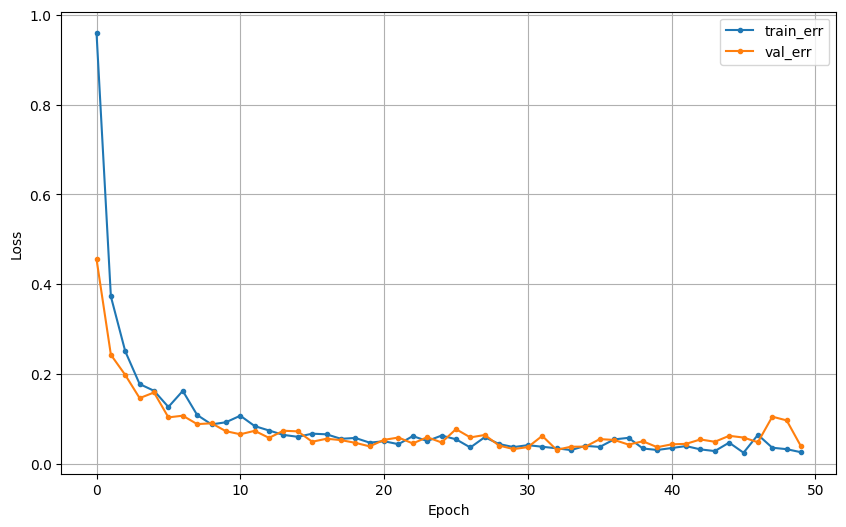

In [138]:
dl_history_plot(history12)

In [139]:
p12 = model12.predict(x_val)
p12 = p12.argmax(axis = 1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [140]:
print(confusion_matrix(y_val, p12))
print(classification_report(y_val, p12))

[[201   1   0   0   0   0]
 [  0 190  21   0   0   0]
 [  0   5 209   0   0   0]
 [  0   0   0 202   0   1]
 [  0   0   0   1 169   0]
 [  0   0   0   0   0 177]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.97      0.90      0.93       211
           2       0.91      0.98      0.94       214
           3       1.00      1.00      1.00       203
           4       1.00      0.99      1.00       170
           5       0.99      1.00      1.00       177

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [141]:
# 각 모델 저장
joblib.dump(model1, 'model1.pkl')
joblib.dump(model2, 'model2.pkl')
joblib.dump(model3, 'model3.pkl')
joblib.dump(model4, 'model4.pkl')
joblib.dump(model5, 'model5.pkl')
joblib.dump(model6, 'model6.pkl')
joblib.dump(model7, 'model7.pkl')
joblib.dump(model7, 'model8.pkl')
joblib.dump(model7, 'model9.pkl')
joblib.dump(model7, 'model10.pkl')
joblib.dump(model7, 'model11.pkl')
joblib.dump(model7, 'model12.pkl')

['model12.pkl']

In [143]:
import joblib
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 타겟 변수 설정
target = 'Activity'

# 테스트 데이터 분할
test_x = test_data.drop(target, axis=1)
test_y = test_data.loc[:, target]

# 스케일링
scaler = MinMaxScaler()
test_x = scaler.fit_transform(test_x)  # 또는 훈련 시 사용한 scaler를 사용해야 함

# 모델 로드
models = [joblib.load(f'model{i}.pkl') for i in range(1, 13)]

# y 레이블 인코딩
label_encoder = LabelEncoder()
test_y_encoded = label_encoder.fit_transform(test_y)

# 각 모델에 대한 성능 측정
for i, model in enumerate(models, start=1):
    # 예측 수행
    y_pred_prob = model.predict(test_x)  # 클래스 확률 예측
    y_pred = y_pred_prob.argmax(axis=1)  # 가장 높은 확률을 가진 클래스를 선택

    # 성능 지표 계산
    accuracy = accuracy_score(test_y_encoded, y_pred)
    precision = precision_score(test_y_encoded, y_pred, average='weighted')
    recall = recall_score(test_y_encoded, y_pred, average='weighted')
    f1 = f1_score(test_y_encoded, y_pred, average='weighted')

    # 결과 출력
    print(f'모델 {i}:')
    print(f' 정확도: {accuracy:.4f}')
    print(f' 정밀도: {precision:.4f}')
    print(f' 재현율: {recall:.2f}')
    print(f' F1 점수: {f1:.2f}')
    print('-' * 30)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
모델 1:
 정확도: 0.9579
 정밀도: 0.9595
 재현율: 0.96
 F1 점수: 0.96
------------------------------
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
모델 2:
 정확도: 0.9708
 정밀도: 0.9714
 재현율: 0.97
 F1 점수: 0.97
------------------------------
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
모델 3:
 정확도: 0.9748
 정밀도: 0.9750
 재현율: 0.97
 F1 점수: 0.97
------------------------------
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
모델 4:
 정확도: 0.8967
 정밀도: 0.9162
 재현율: 0.90
 F1 점수: 0.90
------------------------------
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
모델 5:
 정확도: 0.9300
 정밀도: 0.9413
 재현율: 0.93
 F1 점수: 0.93
------------------------------
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
모델 6:
 정확도: 0.9028
 정밀도: 0.9032
 재현율: 0.90
 F1 점수: 0.90
------------------------------
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
모델 7:
 정확도: 0.3385
 정밀도: 0.3142
 재현율: 0.34
 F1 점수: 0.19
------------------------------
 1/46 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
모델 8:
 정확도: 0.3385
 정밀도: 0.3142
 재현율: 0.34
 F1 점수: 0.19
------------------------------
 1/46 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
모델 9:
 정확도: 0.3385
 정밀도: 0.3142
 재현율: 0.34
 F1 점수: 0.19
------------------------------
 1/46 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
모델 10:
 정확도: 0.3385
 정밀도: 0.3142
 재현율: 0.34
 F1 점수: 0.19
------------------------------
 1/46 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
모델 11:
 정확도: 0.3385
 정밀도: 0.3142
 재현율: 0.34
 F1 점수: 0.19
------------------------------
 1/46 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
모델 12:
 정확도: 0.3385
 정밀도: 0.3142
 재현율: 0.34
 F1 점수: 0.19
------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [146]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 모델 3의 예측 수행
model3 = models[2]  # 모델 3은 리스트의 세 번째 요소이므로 인덱스 2에 해당합니다.
y_pred_prob_model3 = model3.predict(test_x)  # 클래스 확률 예측
y_pred_model3 = y_pred_prob_model3.argmax(axis=1)  # 가장 높은 확률을 가진 클래스를 선택

# 1. Confusion Matrix
conf_matrix = confusion_matrix(test_y_encoded, y_pred_model3)
print("1. confusion_matrix")
print(conf_matrix)

# 2. Classification Report
class_report = classification_report(test_y_encoded, y_pred_model3)
print("\n2. Classification_report")
print(class_report)

# 3. Accuracy Score
accuracy_model3 = accuracy_score(test_y_encoded, y_pred_model3)
print(f"\n3. accuracy_score: {accuracy_model3}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1. confusion_matrix
[[291   0   0   0   1   0]
 [  0 239  15   0   0   0]
 [  0  13 274   0   0   0]
 [  0   0   0 223   4   1]
 [  0   0   0   0 195   0]
 [  0   0   0   1   2 212]]

2. Classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.95      0.94      0.94       254
           2       0.95      0.95      0.95       287
           3       1.00      0.98      0.99       228
           4       0.97      1.00      0.98       195
           5       1.00      0.99      0.99       215

    accuracy                           0.97      1471
   macro avg       0.98      0.98      0.98      1471
weighted avg       0.97      0.97      0.97      1471


3. accuracy_score: 0.9748470428280082
